## Dump all urls from scraped jsons into aria2c compatible input file
Current workflow takes an input directory `SCRAPED_DIR` (containing scraped json of usernames) and creates following text files in the current working dir:
1. all_image_urls.txt (Insta CDN urls for Images of all users)
2. all_urls.txt (Insta CDN urls for Images + Video of all users)
3. url_to_filename.json (Mapping from each url to its downloaded image's filename)
4. aria2c_input_file.txt (to be passed as input to aria2c, see aria2c command below)

In [1]:
import json
import os
# SCRAPED_DIR = "scraped/instagram"
SCRAPED_DIR  = 'scraped/freakinscreators'

all_urls = []
all_images_urls = []
for file_path in os.listdir(SCRAPED_DIR):
    if not file_path.endswith('.json'):
        continue
    try:
        with open(f"{SCRAPED_DIR}/{file_path}", "r") as file:
            json_data = json.load(file)
        
        for data in json_data['data']['user'].get('edge_felix_video_timeline', {}).get('edges', []):
            display_url = data['node']['display_url']
            video_url = data['node']['video_url']
            all_images_urls.append(display_url)
            all_urls.append(video_url)

        for data in json_data['data']['user'].get('edge_owner_to_timeline_media', {}).get('edges', []):
            display_url = data['node']['display_url']
            all_images_urls.append(display_url)
            for side_post in data['node'].get('edge_sidecar_to_children', {}).get('edges', []):
                all_images_urls.append(side_post['node']['display_url'])

        for data in json_data['data']['user'].get('edge_related_profiles', {}).get('edges', []):
            related_user_profile_pic = data['node']['profile_pic_url']
            all_images_urls.append(related_user_profile_pic)
    except Exception as e:
        print(f"Failed to extract urls from {file_path}: {e}")

all_urls.extend(all_images_urls)
all_urls = list(sorted(set([url for url in all_urls if url is not None])))
all_images_urls = list(sorted(set([url for url in all_images_urls if url is not None])))
print(len(all_urls), len(all_images_urls))
# all_urls

66969 65094


In [2]:
with open("all_urls.txt", "w") as all_urls_file:
    for url in all_urls:
        all_urls_file.write(url + "\n")

with open("all_images_urls.txt", "w") as all_images_urls_file:
    for image_url in all_images_urls:
        all_images_urls_file.write(image_url + "\n")


In [57]:
with open("all_images_urls.txt", "r") as all_images_urls_file:
    all_images_urls = [line.strip() for line in all_images_urls_file]


In [3]:
import hashlib

url_to_filename = {}
for url in all_images_urls:
    ext = ".jpg"
    if ".mp4?" in url:
        ext = ".mp4"
    sha1sum = hashlib.sha1(url.encode()).hexdigest()
    url_to_filename[url] = f"{sha1sum}{ext}"
len(url_to_filename.keys())

65094

In [4]:
[url_to_filename[key] for key in list(url_to_filename.keys())[:10]]

['67de7a51b72686220a6257b4586f091126304589.jpg',
 'c3a43120c66d89d88213e493277587a3e39c9a65.jpg',
 '8d3d9c4c698a2a631823ef1d468df2d027a61a86.jpg',
 'ebf6ad80205b83a5b89e9000f2766a4491a8a105.jpg',
 '7233ef456f59b1cb7a3ace2a3699fc98f752c91c.jpg',
 'af50348e5e88776f73dc0fb545699278edd3785b.jpg',
 '917123a70b831571cfa701b01efd3ffbf8f3f87f.jpg',
 '031385328c9ed9063be78a1cd5d9ff6d2b5c889d.jpg',
 'b8dc66f31907ef9f6de71ac19a99dd236204e913.jpg',
 'db44f69d8546c37349646d5032d9314dbc79e7ba.jpg']

In [5]:
with open("url_to_filename.json", "w") as json_file:
    json.dump(url_to_filename, json_file)

In [1]:
import json

# Load the url_to_filename mapping from the JSON file
with open("url_to_filename.json", "r") as json_file:
    url_to_filename = json.load(json_file)


In [6]:
with open("aria2c_input_file.txt", "w") as f:
    for url, file_name in url_to_filename.items():
        f.write(url + "\n")
        f.write(f" out={file_name}\n")


## aria2c Download command:
1. ulimit -n 65536 # To increase no. of concurrent file operations.

Following download command will skip filenames which have already been downloaded. To overwrite the file: remove ` --conditional-get=true` and add `--allow-overwrite=true`.

2. aria2c -i aria2c_input_file.txt --dir=images --continue=true --max-connection-per-server=16 --split=1 --max-concurrent-downloads=500 --max-overall-download-limit=0 --max-download-limit=0 --console-log-level=warn --summary-interval=0 --disk-cache=128M  --conditional-get=true

## Loading images of a user

In [3]:
import json

# SCRAPED_DIR = "scraped/instagram"
ROOT_DIR = "/home/azureuser/husnstorage/instagram"
SCRAPED_DIR  = f'{ROOT_DIR}/freakinscreators'
# username = "emitaz"
username = "srishtiojhaa"
with open(f"{SCRAPED_DIR}/{username}.json") as f:
    username_data = json.load(f)
# username_data
all_images_urls = []
all_urls = []
for data in username_data['data']['user'].get('edge_felix_video_timeline', {}).get('edges', []):
    display_url = data['node']['display_url']
    video_url = data['node']['video_url']
    all_images_urls.append(display_url)
    all_urls.append(video_url)

for data in username_data['data']['user'].get('edge_owner_to_timeline_media', {}).get('edges', []):
    display_url = data['node']['display_url']
    all_images_urls.append(display_url)
    for side_post in data['node'].get('edge_sidecar_to_children', {}).get('edges', []):
        all_images_urls.append(side_post['node']['display_url'])

# for data in username_data['data']['user'].get('edge_related_profiles', {}).get('edges', []):
#     related_user_profile_pic = data['node']['profile_pic_url']
#     all_images_urls.append(related_user_profile_pic)
all_urls.extend(all_images_urls)
print(len(all_urls), len(all_images_urls))

61 61


In [4]:
IMAGE_DOWNLOAD_DIR = f"{ROOT_DIR}/images_freakinscreators"
with open(f"{ROOT_DIR}/url_to_filename.json") as f:
    url_to_filename = json.load(f)
user_filenames = [f"{IMAGE_DOWNLOAD_DIR}/{url_to_filename[url]}" for url in all_images_urls]

In [6]:
from PIL import Image
images = []
for f in user_filenames:
    try:
        img = Image.open(f)
        images.append(img)
    except Exception as e:
        print(f"Error opening image {f}: {e}")

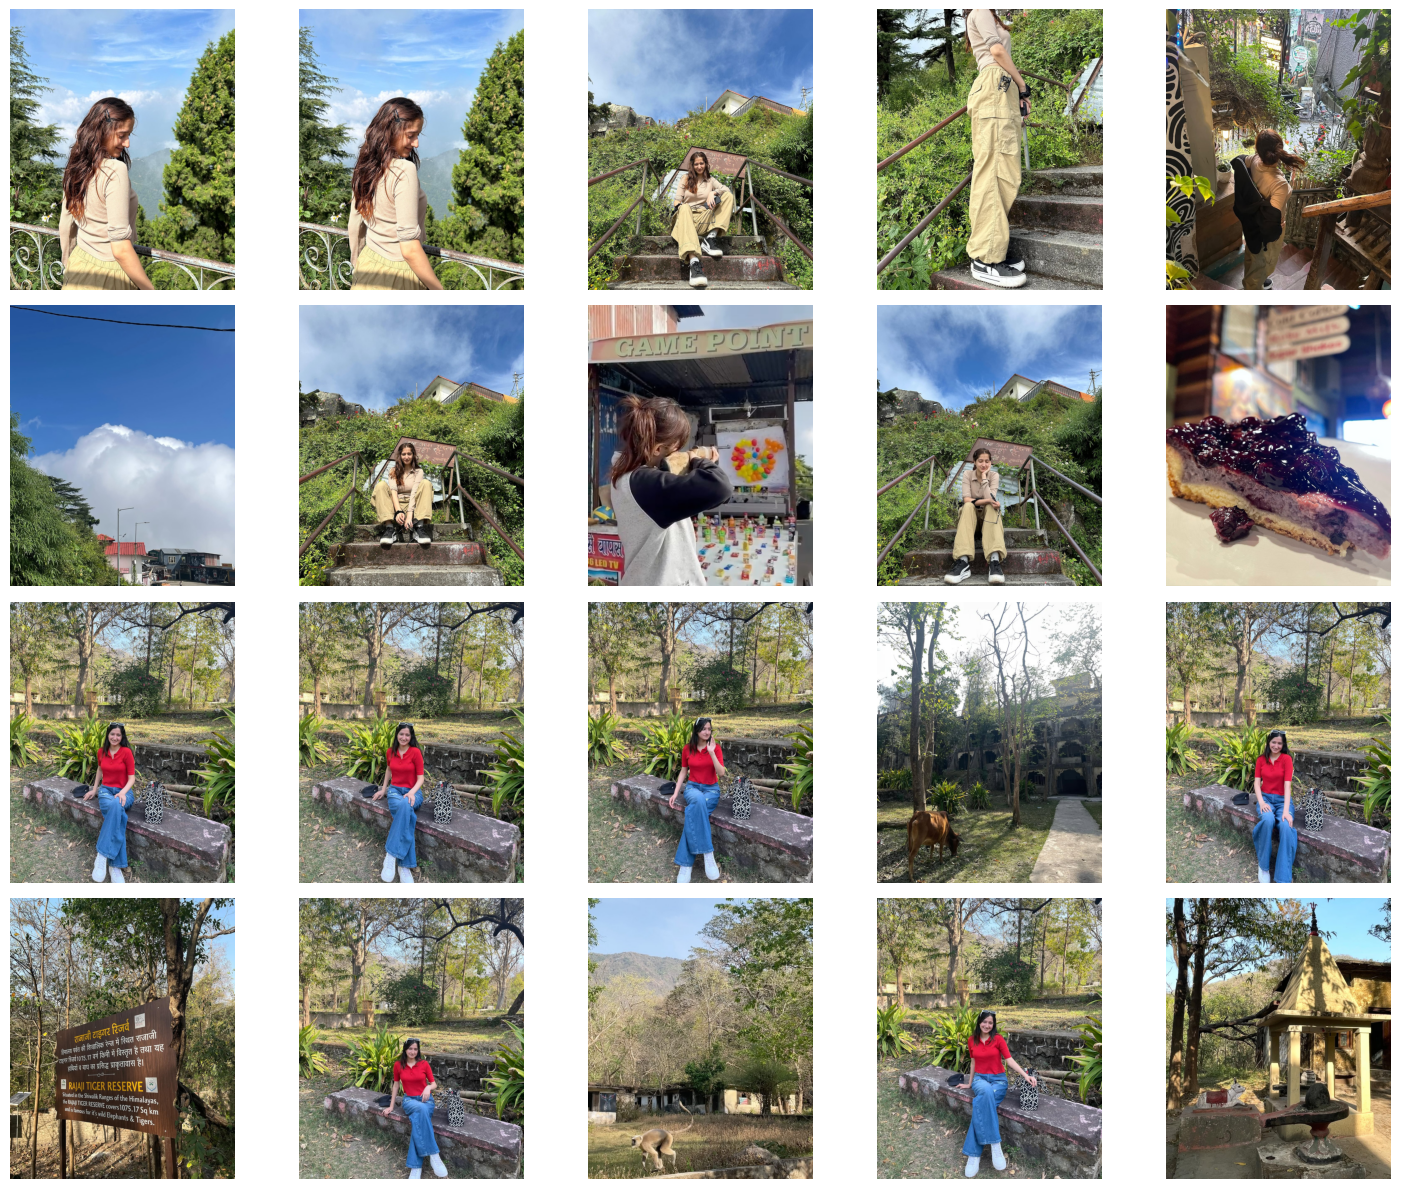

In [9]:
import matplotlib.pyplot as plt

# Select the first 20 images from the images list
images_to_plot = images[:20]

# Create a figure and a set of subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # Adjusted to 4 rows and 5 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each image in the grid
for ax, img in zip(axes, images_to_plot):
    ax.imshow(img)
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()
